In [216]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [217]:
# Data preprocessing for hand data
root_dir = '/Users/mariaclarelusardi/1 Projects/Classes/ECE 598/HandClapRobot/trajectories'
pattern = re.compile(r".*_hand_joints_.*.csv$")
seq_length = 1     # If I decide to change this later, will need to make a function that sequences the data
test_percent = 0.25         # May tune depending on amount of data

joint_data = []
classifier_labels = []          # this is for training the classifier, contains ground truth gesture names for each sample
label_to_int = {}               # maps string gesture names to numbers
j = 0                           # Counter variable for assigning gesture names to numbers
end_pose_labels = []            # this is for training the end pose predictor, contains the end position of the hands 

gesture_classes = os.listdir(root_dir)              # Assumed directory contains a folder for each gesture
gesture_classes = ['front_five']  # For testing until I get all the data
longest_samp = 0                  # Store length of longest sample we find for padding purposes

for gesture in gesture_classes:
    if gesture not in label_to_int:
            label_to_int[gesture] = j
            j += 1
    class_dir = os.path.join(root_dir, gesture)
    participants = os.listdir(class_dir)
    participants = ['isaac'] # For debugging - don't have split for myself yet

    for participant in participants:
        data_dir = os.path.join(class_dir, participant)
        samples = sorted(os.listdir(data_dir))      # Sorting makes debugging easier
        print(samples)
        # samples = ['2025_11_14_14_21_18'] # For debugging
        for sample in samples:
            total_sample = []
            end_pose = []
            sample_dir = os.path.join(data_dir, sample) 
            files = sorted([f for f in os.listdir(sample_dir) if pattern.search(f)])  # guarantee alphabetical order (left hand before right)
            for filename in files:
                hand_joints = pd.read_csv(sample_dir + f'/{filename}')
                hand_joints = hand_joints.drop(['stamp_sec', 'stamp_nanosec', 'Wrist_x', 'Wrist_y', 'Wrist_z'], axis=1)
                end_pose.append(hand_joints[['Palm_x', 'Palm_y', 'Palm_z']].iloc[-1].values)        # Robot end effector is tracking the palm joint
                total_sample.append(torch.from_numpy(hand_joints.values).to(dtype=torch.float32))
            
            total_sample = torch.cat(total_sample, axis=1)          # Concatenating left and right hand data
            if total_sample.shape[0] > longest_samp:
                longest_samp = total_sample.shape[0]
            joint_data.append(total_sample)
            classifier_labels.append(label_to_int[gesture])                     # Appending the assigned number to the label
            end_pose_labels.append(torch.tensor(np.concatenate(end_pose), dtype=torch.float32))
        print("longest_sample: ", longest_samp)

# Weird thing that nn.functional.pad requires a dummy 'channel' dimension that it doesn't even use, hence adding None here and then removing it
joint_data = [F.pad(t[None, :, :], (0, 0, 0, longest_samp - t.shape[0]), mode='replicate').squeeze(0) for t in joint_data]
joint_gesture_data = [torch.cat((j, torch.tensor(l).expand(longest_samp,1)), dim=1) for j, l in zip(joint_data, classifier_labels)]

############## Train/Test data for the gesture classifier model ##########################
X_train_gestures, X_test_gestures, y_train_gestures, y_test_gestures = \
    train_test_split(joint_data, classifier_labels, test_size=test_percent, random_state=42, shuffle=True)

X_train_gestures = torch.stack(X_train_gestures)
X_test_gestures = torch.stack(X_test_gestures)
y_train_gestures = torch.tensor(y_train_gestures)
y_test_gestures = torch.tensor(y_test_gestures)

train_gesture_dataset = TensorDataset(X_train_gestures, y_train_gestures)
train_gesture_loader = DataLoader(train_gesture_dataset, batch_size=None, shuffle=True)

test_gesture_dataset = TensorDataset(X_test_gestures, y_test_gestures)
test_gesture_loader = DataLoader(test_gesture_dataset, batch_size=None)

############## Train/Test data for the end_pose model ##########################
X_train_pose, X_test_pose, y_train_pose, y_test_pose = \
    train_test_split(joint_gesture_data, end_pose_labels, test_size=test_percent, random_state=42, shuffle=True)

X_train_pose = torch.stack(X_train_pose)
X_test_pose = torch.stack(X_test_pose)
y_train_pose = torch.stack(y_train_pose)
y_test_pose = torch.stack(y_test_pose)

train_pose_dataset = TensorDataset(X_train_pose, y_train_pose)
train_pose_loader = DataLoader(train_pose_dataset, batch_size=None, shuffle=True)

test_pose_dataset = TensorDataset(X_test_pose, y_test_pose)
test_pose_loader = DataLoader(test_pose_dataset, batch_size=None)


['2025_11_14_14_21_18', '2025_11_14_14_21_59', '2025_11_14_14_22_24', '2025_11_14_14_22_47', '2025_11_14_14_23_12', '2025_11_14_14_23_33', '2025_11_14_14_23_59', '2025_11_14_14_24_32', '2025_11_14_14_25_00', '2025_11_14_14_25_23', '2025_11_14_14_25_53']
longest_sample:  360


In [218]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()                                           # initialize the superclass from nn.Module for LSTM
        self.hidden_dim = hidden_dim                                                # How many nodes are in each hidden layer?
        self.layer_dim = layer_dim                                                  # How many hidden layers are there?
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim)     # Also giving number of features in input
        self.fc = nn.Linear(hidden_dim, output_dim)                                 # Fully connected layer for giving output, needs to know output dimensions

    def forward(self, x, h0=None, c0=None):
        # h0 is hidden state (aka short term memory)
        # c0 is cell state (aka long term memory)
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out, hn, cn

In [229]:
# Training model for gesture classification

# Hyperparams
input_dim = 150
output_dim = 6
hidden_dim = 100
layer_dim = 1
num_epochs = 100

gesture_model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim)
gesture_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gesture_model.parameters(), lr=0.01)       # Adaptive moment estimation (Adam) for automatically adjusting the learning rate

In [230]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
h0, c0 = None, None

for epoch in range(num_epochs):
    gesture_model.train()
    # running_loss = 0.0
    # correct_train = 0
    # total_train = 0
    
    for i, (inputs, label) in enumerate(train_gesture_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, h0, c0 = gesture_model(inputs, h0, c0)
        loss = gesture_criterion(outputs[-1, :], label)           # Comparing model outputs with ground truth
        loss.backward()                                       # Backpropagation
        optimizer.step()                                      # Optimize all weights and biases
        # running_loss += loss.item()
        h0, c0 = h0.detach(), c0.detach()                     # Get new long and short term memory variables (detached from their gradients)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0000
Epoch [20/100], Loss: 0.0000
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0000
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


In [231]:
# Training model for end pose prediction

# Hyperparams
input_dim = 151
output_dim = 6
hidden_dim = 100
layer_dim = 1
num_epochs = 100

pose_model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim)
pose_criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gesture_model.parameters(), lr=0.01) 

In [232]:
h0, c0 = None, None

for epoch in range(num_epochs):
    pose_model.train()
    # running_loss = 0.0
    # correct_train = 0
    # total_train = 0
    
    for i, (inputs, label) in enumerate(train_pose_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, h0, c0 = pose_model(inputs, h0, c0)
        loss = pose_criterion(outputs[-1, :], label)           # Comparing model outputs with ground truth
        loss.backward()                                       # Backpropagation
        optimizer.step()                                      # Optimize all weights and biases
        # running_loss += loss.item()
        h0, c0 = h0.detach(), c0.detach()                     # Get new long and short term memory variables (detached from their gradients)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.5720
Epoch [20/100], Loss: 0.5135
Epoch [30/100], Loss: 0.5135
Epoch [40/100], Loss: 0.5707
Epoch [50/100], Loss: 0.5137
Epoch [60/100], Loss: 0.5361
Epoch [70/100], Loss: 0.5137
Epoch [80/100], Loss: 0.5135
Epoch [90/100], Loss: 0.5720
Epoch [100/100], Loss: 0.5439


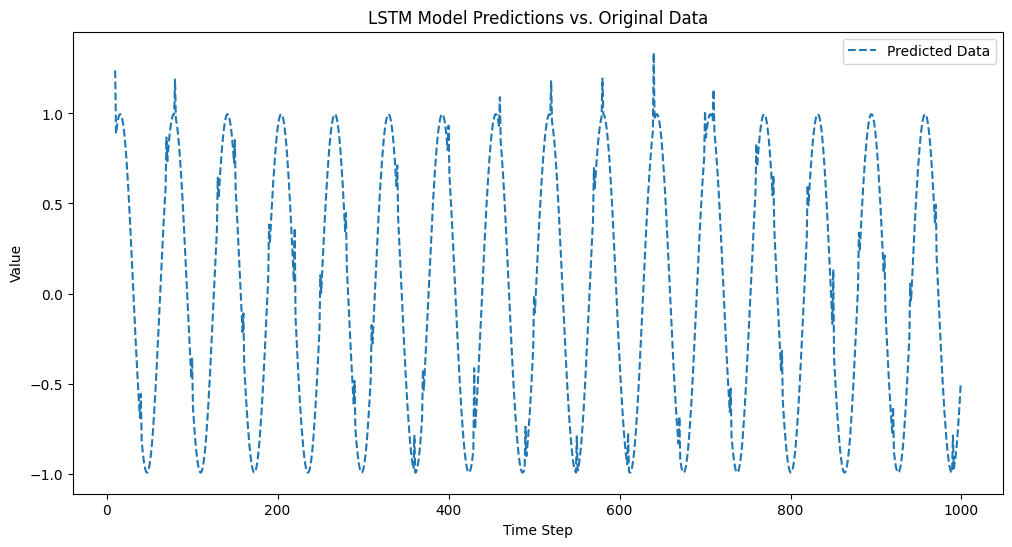

In [ ]:
# Example eval from tutorial - may be suitable for ploting pose error
gesture_model.eval()
predicted, _, _ = model(trainX, h0, c0)

original = data[seq_length:]                    # Don't start predicting until seq_length steps out
time_steps = np.arange(seq_length, len(data))   # Our x values for time steps starting at seq_length and going to the end of the data

predicted[::30] += 0.2
predicted[::70] += 0.2

plt.figure(figsize=(12, 6))
# plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(),
         label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()